# ０～９までの数字の画像からどの数字なのかを推論する畳み込みニューラルネットワーク（CNN）モデルの構築

#### データセットの準備

In [1]:
from datasets import load_dataset
ds = load_dataset("ylecun/mnist")

f:\deep-learning\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

#### データセットの確認

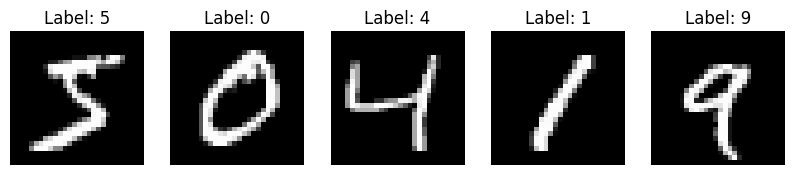

In [3]:
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i, ax in enumerate(axes):
    image = ds['train'][i]['image']
    ax.imshow(image, cmap='gray')
    ax.set_title(f"Label: {ds['train'][i]['label']}")
    ax.axis('off')
plt.show()

In [4]:
ds['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 5}

In [6]:
print(f"画像サイズ {image.size}")

画像サイズ (28, 28)


In [17]:
# 型の変換
ds.set_format(type='torch', columns=['image', 'label'])

#### 畳み込みニューラルネットワークのモデルを定義

In [70]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        # x = x.view(-1, 64)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x

model = CNN()
print(model)

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


##### モデルの動作確認

In [71]:
# 1つ目のデータを取得
train_loader = torch.utils.data.DataLoader(ds['train'])
data_iter = iter(train_loader)
batch = next(data_iter)
images, labels = batch['image'], batch['label']
print(images.size())
print(labels)

torch.Size([1, 1, 28, 28])
tensor([5])


In [72]:
# 1つ目のデータをモデルに入力
pred = model(images.squeeze(2).float())
print(f"output shape: {pred.shape}")
print(pred.min(), pred.max())
print(pred)

output shape: torch.Size([1, 10])
tensor(0.0018, grad_fn=<MinBackward1>) tensor(0.6682, grad_fn=<MaxBackward1>)
tensor([[0.0360, 0.0799, 0.6682, 0.0713, 0.0018, 0.0273, 0.0175, 0.0530, 0.0098,
         0.0351]], grad_fn=<SoftmaxBackward0>)


#### 損失関数とオプティマイザーを設定

In [79]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### モデルを訓練

In [86]:
sample_weights

array([0.00018447, 0.00016883, 0.00017117, ..., 0.00018447, 0.00016898,
       0.00017091])

In [87]:
targets = ds['train']['label'].numpy()
class_counts = np.bincount(targets)
class_weights = 1 / class_counts
sample_weights = class_weights[targets]

sampler = torch.utils.data.WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

In [106]:
# データローダーの作成
train_loader = torch.utils.data.DataLoader(ds['train'], batch_size=64, sampler=sampler)

# モデルの訓練
num_epochs = 1
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data['image'], data['label']
        inputs = inputs.squeeze(2).float()

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()          
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print(f"Epoch {epoch+1}, Iteration {i+1}, Loss: {running_loss / (i+1)}, Accuracy: {100 * correct / total}")
        print("---------------------------------------------")

print('Finished Training')

Epoch 1, Iteration 1, Loss: 1.539275050163269, Accuracy: 92.1875
---------------------------------------------
Epoch 1, Iteration 2, Loss: 1.5783376097679138, Accuracy: 88.28125
---------------------------------------------
Epoch 1, Iteration 3, Loss: 1.586150089899699, Accuracy: 87.5
---------------------------------------------
Epoch 1, Iteration 4, Loss: 1.5783376097679138, Accuracy: 88.28125
---------------------------------------------
Epoch 1, Iteration 5, Loss: 1.6080251216888428, Accuracy: 85.3125
---------------------------------------------
Epoch 1, Iteration 6, Loss: 1.6043792963027954, Accuracy: 85.67708333333333
---------------------------------------------
Epoch 1, Iteration 7, Loss: 1.6084715638841902, Accuracy: 85.26785714285714
---------------------------------------------
Epoch 1, Iteration 8, Loss: 1.6017751395702362, Accuracy: 85.9375
---------------------------------------------
Epoch 1, Iteration 9, Loss: 1.605247351858351, Accuracy: 85.59027777777777
------------

#### 評価

In [117]:
model.eval()
correct = 0

test_loader = torch.utils.data.DataLoader(ds['train'], batch_size=1, shuffle=False)

preds_list = []
actuals_list = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data['image'], data['label']
        images = images.squeeze(2).float()
        outpts = model(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        preds_list.extend(predicted)
        actuals_list.extend(labels)
        print(f"output shape: {outputs.shape}")
        print(f"predicted: {predicted}\nactual: {labels}")
        print(f"Accuracy: {100 * correct / len(preds_list):.2f}%")
        print("---------------------------------------------")

output shape: torch.Size([32, 10])
predicted: tensor([5, 2, 5, 4, 0, 6, 1, 8, 7, 8, 6, 3, 4, 7, 4, 5, 8, 8, 8, 3, 8, 0, 2, 3,
        4, 6, 8, 6, 3, 2, 8, 4])
actual: tensor([5])
Accuracy: 9.38%
---------------------------------------------
output shape: torch.Size([32, 10])
predicted: tensor([5, 2, 5, 4, 0, 6, 1, 8, 7, 8, 6, 3, 4, 7, 4, 5, 8, 8, 8, 3, 8, 0, 2, 3,
        4, 6, 8, 6, 3, 2, 8, 4])
actual: tensor([0])
Accuracy: 7.81%
---------------------------------------------
output shape: torch.Size([32, 10])
predicted: tensor([5, 2, 5, 4, 0, 6, 1, 8, 7, 8, 6, 3, 4, 7, 4, 5, 8, 8, 8, 3, 8, 0, 2, 3,
        4, 6, 8, 6, 3, 2, 8, 4])
actual: tensor([4])
Accuracy: 10.42%
---------------------------------------------
output shape: torch.Size([32, 10])
predicted: tensor([5, 2, 5, 4, 0, 6, 1, 8, 7, 8, 6, 3, 4, 7, 4, 5, 8, 8, 8, 3, 8, 0, 2, 3,
        4, 6, 8, 6, 3, 2, 8, 4])
actual: tensor([1])
Accuracy: 8.59%
---------------------------------------------
output shape: torch.Size([32, 10])


KeyboardInterrupt: 

In [108]:
print(f"pred: {preds_list[:10]}")
print(f"acture: {actuals_list[:10]}")

pred: [tensor(5), tensor(2), tensor(5), tensor(4), tensor(0), tensor(6), tensor(1), tensor(8), tensor(7), tensor(8)]
acture: [tensor(5), tensor(0), tensor(4), tensor(1), tensor(9), tensor(2), tensor(1), tensor(3), tensor(1), tensor(4)]


##### ヒートマップでビジュアライズ

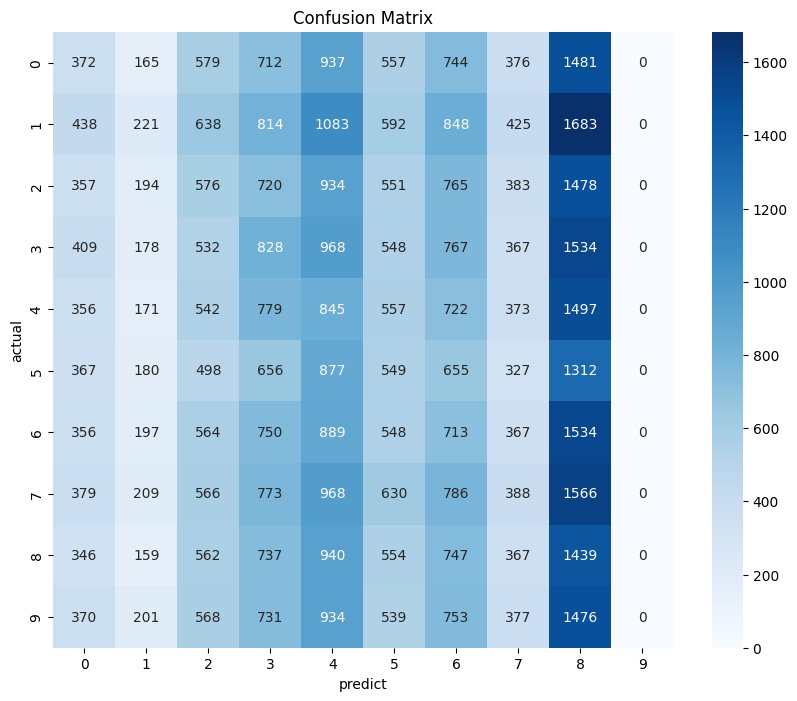

In [109]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Ensure both lists have the same length
preds_list = preds_list[:len(actuals_list)]

cm = confusion_matrix(actuals_list, preds_list)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("predict")
plt.ylabel("actual")
plt.show()